<a href="https://colab.research.google.com/github/rammyram/pytorch_tutorials/blob/master/pytorch_tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Dataset 

In [0]:
import os
import torch 
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms,utils
import pandas as pd 
import numpy as np 
from skimage import transform
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.ion()

import urllib
import zipfile
import os ,shutil

In [0]:
# download the faces.zip:
urllib.request.urlretrieve('https://download.pytorch.org/tutorial/faces.zip' , 'faces.zip' )

with zipfile.ZipFile( 'faces.zip'  , 'r' ) as handle:
  handle.extractall(  '/content' )

os.remove('faces.zip')

In [0]:
root_dir = '/content/faces/'
csv_file = 'face_landmarks.csv'
df = pd.read_csv(  os.path.join( root_dir , csv_file ) )
df.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,part_4_y,part_5_x,part_5_y,part_6_x,part_6_y,part_7_x,part_7_y,part_8_x,part_8_y,part_9_x,part_9_y,part_10_x,part_10_y,part_11_x,part_11_y,part_12_x,part_12_y,part_13_x,part_13_y,part_14_x,part_14_y,part_15_x,part_15_y,part_16_x,part_16_y,part_17_x,part_17_y,part_18_x,part_18_y,part_19_x,...,part_48_x,part_48_y,part_49_x,part_49_y,part_50_x,part_50_y,part_51_x,part_51_y,part_52_x,part_52_y,part_53_x,part_53_y,part_54_x,part_54_y,part_55_x,part_55_y,part_56_x,part_56_y,part_57_x,part_57_y,part_58_x,part_58_y,part_59_x,part_59_y,part_60_x,part_60_y,part_61_x,part_61_y,part_62_x,part_62_y,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,139,49,150,60,159,73,166,87,168,100,166,111,160,120,151,128,141,133,128,137,116,138,102,138,89,44,70,53,66,63,...,71,137,78,131,85,127,90,129,94,129,99,134,103,142,97,144,92,145,88,145,83,144,77,141,75,137,85,134,89,135,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,320,100,340,111,359,126,375,149,379,175,376,197,364,218,346,236,322,249,296,254,266,256,237,256,207,65,210,69,197,80,...,110,314,117,310,126,308,135,309,147,307,164,306,184,307,167,317,152,321,139,323,130,322,120,318,114,313,127,312,136,313,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,169,80,180,91,189,103,195,115,197,128,197,139,192,148,184,154,173,160,162,164,150,169,138,171,126,80,101,87,95,98,...,101,163,109,157,117,155,123,157,129,156,134,160,139,168,133,171,126,172,120,172,114,171,107,168,104,162,116,161,122,162,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,220,89,238,108,255,129,268,155,268,180,261,203,244,222,224,238,199,247,172,248,144,245,116,241,87,39,114,45,102,57,...,98,207,107,199,120,193,131,193,142,188,162,185,184,187,168,206,151,218,139,222,127,223,113,219,103,206,122,203,133,201,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,536,186,567,214,594,249,614,290,616,329,608,363,589,390,562,411,529,421,491,425,450,425,409,423,370,162,345,178,330,200,...,228,514,246,502,264,495,278,499,292,495,315,502,341,511,318,530,297,538,281,539,266,537,248,529,239,513,265,507,278,509,293,507,331,511,294,516,279,518,265,516


In [0]:
# read a sample image :
n = 65 # sample_idx
img_name = df.iloc[n,0]
landmarks = np.array(df.iloc[n,1:] , dtype = np.float).reshape( -1, 2 )

img_name , landmarks[:4,:]

('person-7.jpg', array([[32., 65.],
        [33., 76.],
        [34., 86.],
        [34., 97.]]))

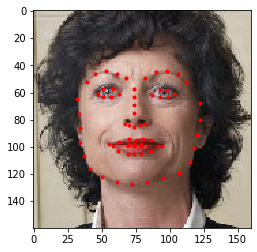

In [0]:
# function to show image and its landmarks :
def showimg( image , landmarks ):  
  plt.imshow( image )
  plt.scatter( landmarks[:,0] , landmarks[:,1] , marker='.' , c='r' )

img_path = os.path.join(  root_dir ,img_name)
showimg(plt.imread( img_path )  , landmarks )

In [0]:
# Create a custom dataset class :

class FaceLandmarkDataset( Dataset ):
  def __init__(self ,csv_file , root_dir , transform = None ):
    super( FaceLandmarkDataset , self ).__init__()
    self.df = pd.read_csv( os.path.join( root_dir , csv_file ) )
    self.root_dir = root_dir 
    self.transform = transform 
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    img_name = self.df.iloc[idx,0]
    image = plt.imread( os.path.join( self.root_dir , img_name ) )
    landmarks = np.array(self.df.iloc[idx,1:] , dtype = np.float).reshape( -1, 2 )
    sample =  { 'image' : image , 'landmarks': landmarks }  
    if self.transform:
      sample = self.transform(sample)
    return sample 

(324, 215, 3) (68, 2)
(500, 333, 3) (68, 2)
(250, 258, 3) (68, 2)
(434, 290, 3) (68, 2)


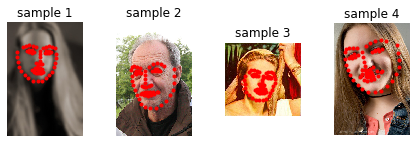

In [0]:
face_dataset = FaceLandmarkDataset( csv_file , root_dir  )
#plot samples :
for i in range( len(face_dataset) ):
  sample = face_dataset[i]
  print( sample['image'].shape , sample['landmarks'].shape )

  ax = plt.subplot( 1 ,4 ,i+1 )
  plt.tight_layout()
  ax.set_title( 'sample {}'.format( i+1) )  
  ax.axis('off')
  showimg(  sample['image'] ,  sample['landmarks']  )
  if i==3:
    break

In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

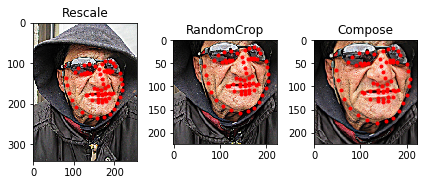

In [0]:
# Compose Transforms :
scale = Rescale( 256 )
crop = RandomCrop( 224 )
composed = transforms.Compose( [scale , crop ] )

# Visualize sample transforms 
sample = dataset[15] 
for i,tsfm in enumerate( [ scale, crop , composed ] ):
  sample = tsfm( sample )
  plt.tight_layout()
  ax = plt.subplot( 1,3,i+1 )  
  ax.set_title( type(tsfm).__name__ )    
  showimg( **sample )


In [0]:
transformed_dataset = FaceLandmarkDataset(csv_file,
                                           root_dir,
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


# Tensorboard

Reinitialized existing Git repository in /content/.git/

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@a84ae94c7e10.(none)')
